In [1]:
import h5py
import numpy as np
import pandas as pd 
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])

In [3]:
df = pd.read_csv("/home/pravn/Dropbox/Masters/Research Data/results.csv", index_col=0)

In [4]:
df.head()

,sobject_id,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,...,label,star_id,teff,e_teff,logg,e_logg,fe_h,e_fe_h,ra,dec
0,131116000501262,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,...,1,03303061-6824089,5848.8174,109.977853,4.243084,0.184408,-0.338275,0.134476,52.627905,-68.402358
1,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,2,04315418-5613335,4328.7964,118.017575,3.327391,0.198075,0.169383,0.128575,67.975753,-56.225897
2,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,4,04303269-5730244,3136.7622,NaN,4.396316,NaN,NaN,NaN,67.635947,-57.506949
3,131118002401396,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,...,2,04354318-5738560,4815.8853,140.982633,3.473381,0.215505,-0.916787,0.134253,68.930000,-57.648952
4,131118002901052,0.958085,0.961354,0.958334,0.960897,0.960540,0.954966,0.951380,0.939908,0.923267,...,2,05292291-5823105,5056.8890,84.699254,3.586107,0.183447,-0.459082,0.065107,82.345409,-58.386368


In [115]:
Y = df.loc[6314,"6561.00000000059":"6565.44000000062"].values
galah_id = df.loc[6314, "sobject_id"]
x = wl_grid[PLOT_MASK]

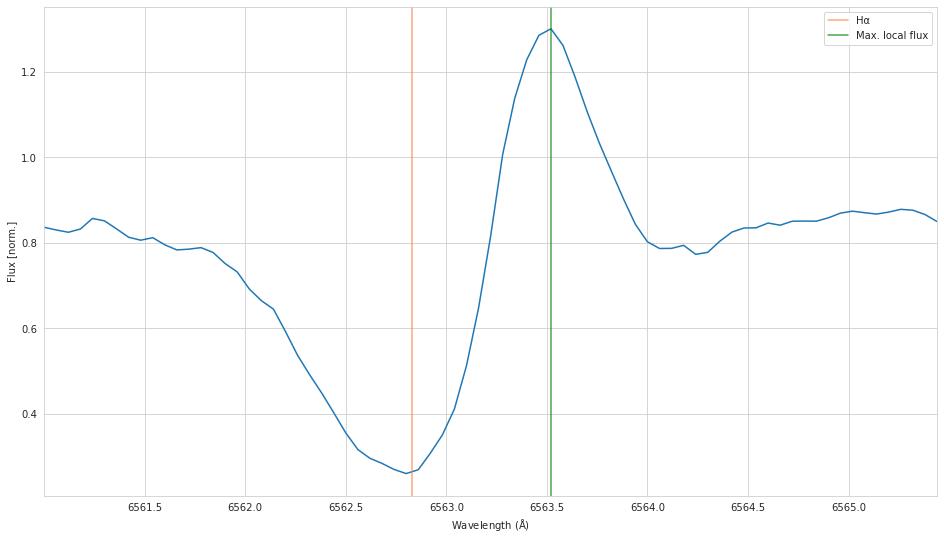

In [116]:
plt.plot(wl_grid[PLOT_MASK], Y)
plt.axvline(x=6562.83, color='coral', label="Hα", alpha=0.7)
plt.axvline(x=wl_grid[PLOT_MASK][np.argmax(Y)], color='green', label="Max. local flux",alpha=0.7)
plt.xlabel("Wavelength ($\mathrm{\AA}$)", size=10)
plt.ylabel("Flux [norm.]", size=10)
plt.xlim(wl_grid[PLOT_MASK].min(), wl_grid[PLOT_MASK].max())
plt.legend()

In [118]:
def double_gaussian(x, a1, b1, c1, a2, b2, c2, a3):
    return a1*np.exp(-np.power(x - b1, 2)/(2*np.power(c1, 2))) + a2*np.exp(-np.power(x - b2, 2)/(2*np.power(c2, 2))) + (a3)

In [119]:
pars, cov = curve_fit(f=double_gaussian, xdata=wl_grid[PLOT_MASK], ydata=Y, p0=[0.4, wl_grid[PLOT_MASK][np.argmin(Y)], 0.1, 1.2, wl_grid[PLOT_MASK][np.argmax(Y)], 0.0003, 1],
bounds=((-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf)))

In [120]:
a1 = pars[0]
b1 = pars[1]
c1 = pars[2]
a2 = pars[3]
b2 = pars[4]
c2 = pars[5]
a3 = pars[6]

In [121]:
f1 = a1*np.exp(-np.power(x - b1, 2)/(2*np.power(c1, 2)))
f2 = a2*np.exp(-np.power(x - b2, 2)/(2*np.power(c2, 2))) + a3
Y_fit = f1 + f2

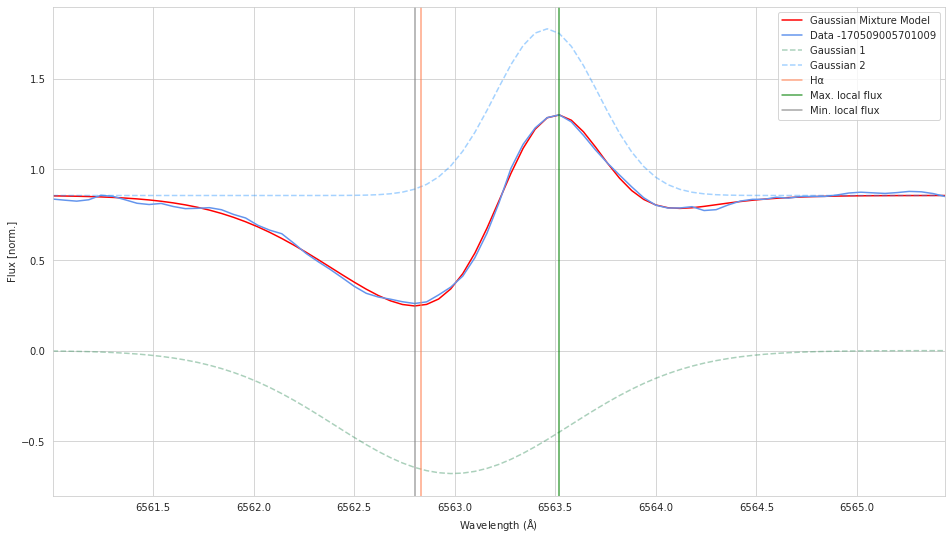

In [140]:
plt.plot(x, Y_fit, color='red', label="Gaussian Mixture Model")
plt.plot(x, Y, color='cornflowerblue', label="Data -"+str(galah_id))
plt.plot(x, f1, color='seagreen', label="Gaussian 1", alpha=0.4, linestyle="--")
plt.plot(x, f2, color='dodgerblue', label="Gaussian 2", alpha=0.4, linestyle="--")
plt.axvline(x=6562.83, color='coral', label="Hα", alpha=0.7)
plt.axvline(x=wl_grid[PLOT_MASK][np.argmax(Y)], color='green', label="Max. local flux",alpha=0.7)
plt.axvline(x=wl_grid[PLOT_MASK][np.argmin(Y)], color='gray', label="Min. local flux",alpha=0.7)
plt.xlabel("Wavelength ($\mathrm{\AA}$)", size=10)
plt.ylabel("Flux [norm.]", size=10)
plt.xlim(wl_grid[PLOT_MASK].min(), wl_grid[PLOT_MASK].max())
plt.legend()

In [7]:
from lmfit import minimize, Parameters

In [8]:
def residual(params, x, data, uncertainty):
    amp1 = params['amp1']
    mu1 = params['mu1']
    sigma1 = params['sigma1']

    amp2 = params['amp2']
    mu2 = params['mu2']
    sigma2 = params['sigma2']

    model = amp1*np.exp(-np.power(x - mu1, 2)/(2*np.power(sigma1, 2))) + 1 + amp2*np.exp(-np.power(x - mu2, 2)/(2*np.power(sigma2, 2)))

    return (data-model) / uncertainty

In [9]:
params = Parameters()

params.add('amp1', value=0.6)
params.add('mu1', value=wl_grid[PLOT_MASK][np.argmin(Y)])
params.add('sigma1', value=0.1)

params.add('amp2', value=0.4)
params.add('mu2', value=wl_grid[PLOT_MASK][np.argmax(Y)])
params.add('sigma2', value=0.07)


In [10]:
data = Y

In [26]:
X = wl_grid[PLOT_MASK]

In [13]:
out = minimize(residual, params, args=(x, data, uncertainty))

NameError: name 'uncertainty' is not defined

In [63]:
from lmfit.models import ExpressionModel

In [97]:
gmod = ExpressionModel("amp1*np.exp(-(x - mu1)**2/(2*sigma1**2))")

In [98]:
params = gmod.make_params(amp1=0.6, mu1=6562.7, sigma1=0.1)

In [99]:
y = gmod.eval(params, x=x)

AttributeError: at expr='amp1*np.exp(-(x - mu1)**2/(2*sigma1**2))'

In [96]:
print(y)

None


In [95]:
result = gmod.fit(Y, x=X, amp1=0.6, mu1=6562.7, sigma1=0.1, amp2=0.09)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [28]:
from lmfit.models import GaussianModel

In [29]:
x = wl_grid[PLOT_MASK]
y = Y

In [30]:
mod = GaussianModel()

In [31]:
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4146
    # data points      = 75
    # variables        = 3
    chi-square         = 4.05816540
    reduced chi-square = 0.05636341
    Akaike info crit   = -212.756783
    Bayesian info crit = -205.804319
[[Variables]]
    amplitude:  2.3503e+08 +/- 8.9745e+11 (381839.94%) (init = 6.928235)
    center:     6957.97318 +/- 102270.553 (1469.83%) (init = 6563.509)
    sigma:      73.7455103 +/- 9556.92244 (12959.33%) (init = 2.22)
    fwhm:       173.657403 +/- 22504.8320 (12959.33%) == '2.3548200*sigma'
    height:     1271455.36 +/- 4.6902e+09 (368880.66%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, center) = 1.000
    C(center, sigma)     = 1.000
    C(amplitude, sigma)  = 1.000


30.867231759879544
159.99737308817748
-9.889521860206143
probably quite close, already
[-10.01156382 159.95204337 -30.00810427]


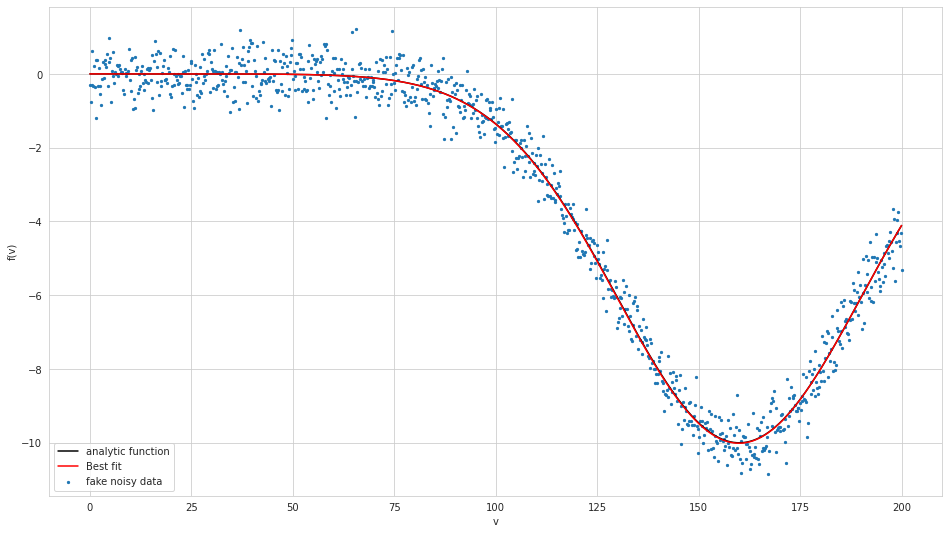

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.integrate import cumtrapz

def func( x, a, x0, sigma ):
    return a * np.exp( -( x - x0 )**2 / ( 2 * sigma**2 ) )
    
amplitude = -10
peak_width = 30
x_peak_loc = 160

# Generating clean data
xl = np.linspace( 0, 200, 1000 )
y0 = func( xl, amplitude, x_peak_loc, peak_width )

mn = 0
N = 0.2
std = np.sqrt( N )
noise2 = np.random.normal( mn, std, size=len( xl ) )
yl = y0 + noise2

"""
Most simple implementation of the linear fit of mu and sigma
"""
nul = yl - yl[0]

Sk = cumtrapz( yl, x=xl, initial=0 )
Tk = cumtrapz( xl * yl, x=xl, initial=0 )

MX = [
        [ np.dot( Sk, Sk ), np.dot( Sk, Tk ) ],
        [ np.dot( Sk, Tk ), np.dot( Tk, Tk ) ]
    ]
Vek = [ np.dot( nul, Sk ), np.dot( nul, Tk ) ]

res = np.dot( np.linalg.inv( MX ), Vek )
sig = np.sqrt( -1 / res[1] )
mu = res[0] * sig**2 
print( sig )
print( mu )
"""
Most simple linear fit of amplitude, probably not required but...hey.
"""
fk = func( xl, 1, mu, sig )
amp = np.dot( yl, fk ) / np.dot( fk, fk )
print( amp )
print( "probably quite close, already")

popt, pcov = curve_fit( func, xl, yl, p0=( sig, mu, amp ) ) 
print( popt )

fig = plt.figure( 1 )
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( xl, y0, c='k', label="analytic function" )
ax.scatter( xl, yl, s=5, label="fake noisy data" )
ym = func( xl, *popt )
ax.plot( xl, ym, c='r', label="Best fit" )
ax.legend()
fig.savefig( "model_fit.png" )
plt.legend( loc="lower left" )
plt.xlabel( "v" )
plt.ylabel( "f(v)" )
plt.show()